
# Pipeline de Machine Larning - Model

**Some Notes:**

- Since there's no much difference when running or not a fine tuning for the simple models we chose, we decided to not run it since it would bring us a lot more time of processing (specially for the SVM we used).
- Also, we didn't run a lot of models because there's no much difference between their performance in this data.
- Lastly, the performance using only text columns was better than using a mix of text and the other variables. So, we decided to model the data only with the text columns, although using the others would be interesting in the construction of the pipeline in production (since we would have to add scaling, more missing values filtering, etc.)

# 0. Importing

In [1]:
import os
import nltk
import pickle 

import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus                        import stopwords


from sklearn                            import model_selection
from sklearn.svm                        import SVC
from sklearn.metrics                    import confusion_matrix, classification_report
from sklearn.pipeline                   import Pipeline
from sklearn.ensemble                   import RandomForestClassifier
from sklearn.preprocessing              import LabelBinarizer, StandardScaler
from sklearn.model_selection            import GridSearchCV, train_test_split
from sklearn.feature_extraction.text    import CountVectorizer, TfidfTransformer


## 0.1. Helper Functions

In order to let the code be a little bit more clean and understandable, we decided to keep in the following cell some functions which will help us along the notebook.

In [2]:
def create_text_feature(data, stop_words_list):
    """
    Receives dataframe, concatenate its text columns, and remove stopwords.
    
    :param data: a Pandas Dataframe.
    :param stop_words_list: a list of stop words.
    
    :returns: a Pandas Series containing the concatenated string"""
    
    data = data.apply(lambda x: x['title'] + " " + x['query'] + " " + x['concatenated_tags'], axis =1)
    
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    
    return data



def create_fit_pipeline(X, y, model):
    """
    Creates and fits a pipeline for a received set of features and target.
    
    :param X: a pandas Dataframe of features.
    :param y: a a Pandas Series.
    :param model: a scikit-learn instanciated model.
    
    :returns: a fitted pipeline """
    
    pipeline = Pipeline([
        ("counter", CountVectorizer()),

        ("tfidf", TfidfTransformer()),

        ("clf", model)

      ])

    pipeline.fit(X, y)
    

    return pipeline


def load_pickle(file_pkl):
    """
    Receives a path of a pickle file and loads it.
    
    :param file_pkl: str referencing a .pkl file.
    
    :returns: the loaded object"""
    
    with open(file_pkl,'rb') as open_file:

        obj = pickle.load(open_file)
        
    return obj


def save_pickle(obj, path_name):
    """
    Receives and object and saves it in the received path.
    
    :param obj: any pickle serializable object.
    :param path_name: str referencing the path where the object is going to be saved.
    
    """
    
    with open(path_name, 'wb') as file:
        
        pickle.dump(obj, file)
        
        
def plot_cm(y_true, y_hat, labels):
    """
    Receives true and predicted data and plots a Confusion Matrix for them.
    
    :param y_true: Numpy Array of true labels.
    :param y_hat: Numpy Array of predicted labels.
    :param labels: label list to be used in the plot axis ticks.
    
    """
    
    cm = confusion_matrix(y_true, y_hat)
        
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1) 

    ax = sns.heatmap(
                  cm, 
                  annot=True, 
                  fmt=".2f", 
                  cmap='Blues',
                  ax=ax
              )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_title('Confusion Matrix')

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 

    plt.yticks(rotation=0)

    plt.ylim(b, t)

    plt.show()
    
    

## 0.2. Initializing some important variables

In [3]:
# path variables
DATASET_PATH  = os.environ['DATASET_PATH']
TEST_PATH     = os.environ['TEST_PATH']
MODEL_PATH    = os.environ['MODEL_PATH']
METRICS_PATH  = os.environ["METRICS_PATH"]

# downloading and creating a portuguese list fo stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jedipadawan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Extraction

In [4]:
raw_data = pd.read_csv(DATASET_PATH)

test_data = pd.read_csv(TEST_PATH)

# 2. Data Formatting

Let's copy the dataframe to make it easier to re-run the code without having to load the data again.

In [5]:
df = raw_data

In [6]:
X = df.drop('category', axis =1)[['title', 'query', 'concatenated_tags']]

y = df['category']

## 2.1. Filling Missing Values

Since we're just going to use text columns as features, we'll fill missing values only for them.

In [7]:
X.isna().sum()

title                0
query                0
concatenated_tags    2
dtype: int64

Even though there's no missing values in `title` and `query` columns (as shown in the output above), we'll keep filling them with an empty string for future deploy purposes.

In [8]:
X['concatenated_tags'] = X.concatenated_tags.fillna('')

X['title'] = X.concatenated_tags.fillna('')

X['query'] = X.concatenated_tags.fillna('')

## 2.2. Split data into train and validation

Let's get a portion of the data to create a validation dataset to make our future performance analysis more robust.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((30400, 3), (30400,), (7600, 3), (7600,))

In order to check the balance of the target variable in the training and testing set, let's count its frequencies for both sets.

In [10]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies_y_train = np.asarray((unique, counts)).T


(unique, counts) = np.unique(y_valid, return_counts=True)
frequencies_y_valid = np.asarray((unique, counts)).T

print("-- Y train unique values count --")
print(frequencies_y_train, '\n')

print("-- Y valid unique values count --")
print(frequencies_y_valid)

-- Y train unique values count --
[['Bebê' 5544]
 ['Bijuterias e Jóias' 752]
 ['Decoração' 6978]
 ['Lembrancinhas' 14019]
 ['Outros' 907]
 ['Papel e Cia' 2200]] 

-- Y valid unique values count --
[['Bebê' 1386]
 ['Bijuterias e Jóias' 188]
 ['Decoração' 1745]
 ['Lembrancinhas' 3505]
 ['Outros' 226]
 ['Papel e Cia' 550]]


## 2.3. Using text Columns to create the feature

In [11]:
X_train = create_text_feature(X_train, stop_words)

X_valid = create_text_feature(X_valid, stop_words)

## 2.4. Running the entire data preparation for the test dataset

In [13]:
X_test = test_data.drop('category', axis =1)[['title', 'query', 'concatenated_tags']]

y_test = test_data['category']

In [14]:
X_test['concatenated_tags'] = X_test.concatenated_tags.fillna('')

X_test['title'] = X_test.concatenated_tags.fillna('')

X_test['query'] = X_test.concatenated_tags.fillna('')

In [15]:
X_test = create_text_feature(X_test, stop_words)

In [16]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies_y_test = np.asarray((unique, counts)).T

print("-- Y test unique values count --")
print(frequencies_y_test, '\n')

-- Y test unique values count --
[['Bebê' 95]
 ['Bijuterias e Jóias' 11]
 ['Decoração' 122]
 ['Lembrancinhas' 230]
 ['Outros' 15]
 ['Papel e Cia' 27]] 



# 3. Modelling

We decided to fit two different models and chose the best one based on the accuracy, precision, and recall metrics.

Those models are:
- A tree-based model: Random Forest
- A Support vector model: S. V. Classifier

Since both work differently, we'll be able to take a look at the performance of modelling with different model approaches

## 3.1. Random Forest Classifier

In [16]:
rf_model = RandomForestClassifier(n_estimators=300,random_state=42)

In [17]:
%%time
rf_pipeline = create_fit_pipeline(X_train, y_train, rf_model)

CPU times: user 4min 4s, sys: 527 ms, total: 4min 5s
Wall time: 4min 5s


## 3.2. Support Vector Machine Classifier

In [18]:
svc_model = SVC(C=10, kernel="rbf", random_state=42)

In [19]:
%%time
svc_pipeline = create_fit_pipeline(X_train, y_train, svc_model)

CPU times: user 3min 15s, sys: 496 ms, total: 3min 16s
Wall time: 3min 16s


# 4. Model Validation

**Conclusions:**

- Random Forest Classifier: higher precision for some categories, lower recall.
- Support Vector Machine Classifier: lower precision, higher recall. Also, it has a higher f1 score and accuracy.

Since SVM Classifier performed better in terms of recall, which means it has less false negatives than RF classifier, it was chosen as the best model. Also, in terms of f1-score, SVM shows a better balance between precision and recall.

In terms of processing time, SVM Classifier took only about one minute more than RF, even though this difference would be higher if we were using more features.

**Evaluation on Test set:**

The performance on testing dataset was slightly lowest than in the validation set. The overall accuracy, recall and f1-score was lower, indicating that we still have to work better on the model selection and tuning.
Maybe we could overcome this by using other columns as features, which could bring us a more generalization power.

Before evaluating the models, let's create a list containing the target labels to be used in the confusion matrix plot.

In [20]:
target_labels = df['category'].sort_values().unique()

## 4.1. Evaluating model on the validation set

## 4.1.1. Random Forest Classifier

In [21]:
rf_predictions = rf_pipeline.predict(X_valid)

In [33]:
rf_report = classification_report(y_valid, rf_predictions)

with open(METRICS_PATH, "a") as metrics_file:
    
    print("Random Forest Classifier - Validation Metrics", file=metrics_file)
    
    print(rf_report + '\n\n', file=metrics_file)
    
print("Random Forest Classifier - Validation Metrics")

print(rf_report)

Random Forest Classifier - Validation Metrics
                    precision    recall  f1-score   support

              Bebê       0.91      0.84      0.87      1386
Bijuterias e Jóias       0.96      0.85      0.90       188
         Decoração       0.85      0.88      0.87      1745
     Lembrancinhas       0.88      0.94      0.91      3505
            Outros       0.86      0.57      0.68       226
       Papel e Cia       0.87      0.65      0.74       550

          accuracy                           0.88      7600
         macro avg       0.89      0.79      0.83      7600
      weighted avg       0.88      0.88      0.87      7600



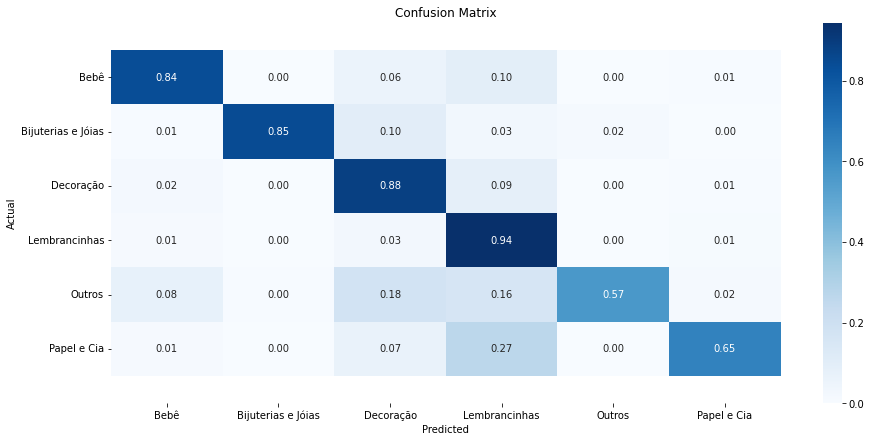

In [23]:
plot_cm(y_valid.values, rf_predictions, target_labels)

## 4.1.2. Support Vector Machine Classifier

In [35]:
svc_predictions = svc_pipeline.predict(X_valid)

In [36]:
svc_report = classification_report(y_valid, svc_predictions)

with open(METRICS_PATH, "a") as metrics_file:
    
    print("Support Vector Classifier - Validation Metrics", file=metrics_file)
    
    print(svc_report + '\n\n', file=metrics_file)
    

print("Support Vector Classifier - Validation Metrics")

print(svc_report)

Support Vector Classifier - Validation Metrics
                    precision    recall  f1-score   support

              Bebê       0.90      0.86      0.88      1386
Bijuterias e Jóias       0.97      0.87      0.92       188
         Decoração       0.89      0.88      0.88      1745
     Lembrancinhas       0.88      0.94      0.91      3505
            Outros       0.86      0.63      0.73       226
       Papel e Cia       0.86      0.71      0.77       550

          accuracy                           0.89      7600
         macro avg       0.89      0.82      0.85      7600
      weighted avg       0.89      0.89      0.88      7600



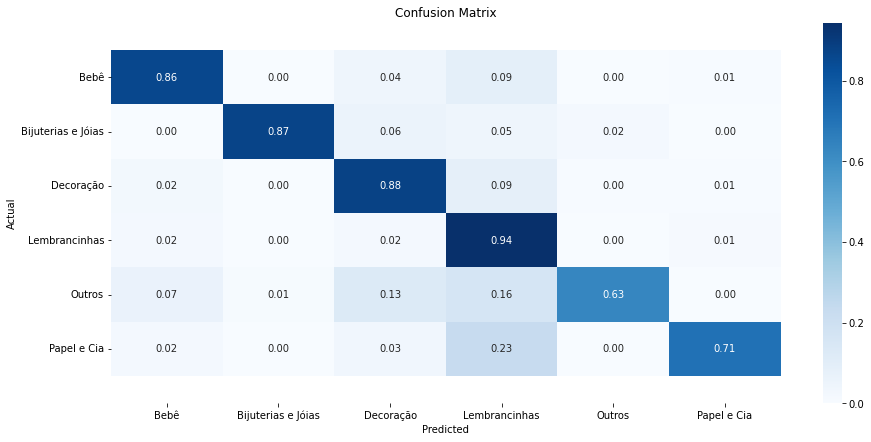

In [27]:
plot_cm(y_valid.values, svc_predictions, target_labels)

## 4.2. Evaluating the chosen model on the test set

Since we chose the best model, let's now take a look at its performance on the testing dataset.

In [37]:
svc_predictions = svc_pipeline.predict(X_test)

In [38]:
svc_report = classification_report(y_test, svc_predictions)

with open(METRICS_PATH, "a") as metrics_file:
    
    print("Support Vector Classifier - Test Metrics", file=metrics_file)
    
    print(svc_report + '\n\n', file=metrics_file)
    

print("Support Vector Classifier - Test Metrics")

print(svc_report)

Support Vector Classifier - Test Metrics
                    precision    recall  f1-score   support

              Bebê       0.93      0.85      0.89        95
Bijuterias e Jóias       1.00      0.82      0.90        11
         Decoração       0.92      0.91      0.91       122
     Lembrancinhas       0.89      0.96      0.92       230
            Outros       0.85      0.73      0.79        15
       Papel e Cia       0.86      0.70      0.78        27

          accuracy                           0.90       500
         macro avg       0.91      0.83      0.86       500
      weighted avg       0.90      0.90      0.90       500



In [39]:
!cat {METRICS_PATH}

Random Forest Classifier - Validation Metrics
                    precision    recall  f1-score   support

              Bebê       0.91      0.84      0.87      1386
Bijuterias e Jóias       0.96      0.85      0.90       188
         Decoração       0.85      0.88      0.87      1745
     Lembrancinhas       0.88      0.94      0.91      3505
            Outros       0.86      0.57      0.68       226
       Papel e Cia       0.87      0.65      0.74       550

          accuracy                           0.88      7600
         macro avg       0.89      0.79      0.83      7600
      weighted avg       0.88      0.88      0.87      7600



Support Vector Classifier - Validation Metrics
                    precision    recall  f1-score   support

              Bebê       0.90      0.86      0.88      1386
Bijuterias e Jóias       0.97      0.87      0.92       188
         Decoração       0.89      0.88      0.88      1745
     Lembrancinhas       0.88      0.94      0.91      3505
 

# 5. Model exportation

In [30]:
save_pickle(svc_pipeline, MODEL_PATH)